In [83]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

print(tf.__version__)

2.1.0


In [123]:
df_sig = pd.read_csv("ROOT/sig.csv")
df_sig_test = df_sig.sample(frac=0.2).reset_index(drop=True)
df_sig.drop(df_sig_test.index, inplace=True)
df_bkg = pd.read_csv("ROOT/bkg.csv")
df_bkg_test = df_bkg.sample(frac=0.2).reset_index(drop=True)
df_bkg.drop(df_bkg_test.index, inplace=True)
df_train = pd.concat([df_sig,df_bkg], ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [129]:

def runBDT(df, rf=False):
    X = df.drop(columns=['class'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.1, random_state=None)
    
    """ Fit the decision tree
    """
    if rf: classifier = ensemble.RandomForestClassifier(max_depth=5, n_estimators=100, criterion='gini')
    else: classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.02, objective='multi:softprob', num_class=2,
                                   n_jobs=8, subsample=0.2, colsample_bytree=0.5, n_estimators=500)
    classifier = classifier.fit(x_train, y_train)
    
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    
    X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class']).columns)
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_shap)
    # shap.summary_plot(shap_values, X_shap, plot_type='violin')
    shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=["bkg", "sig"], class_inds='original')
    return classifier, x_test, y_test


Accuracy Score: 98.34% 


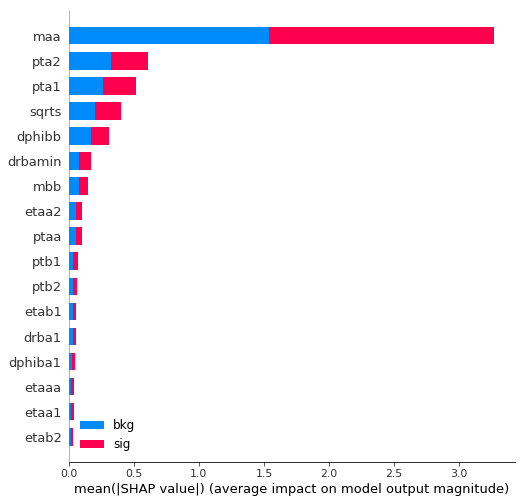

In [130]:
classifier, x_test, y_test = runBDT(df_train, rf=False)

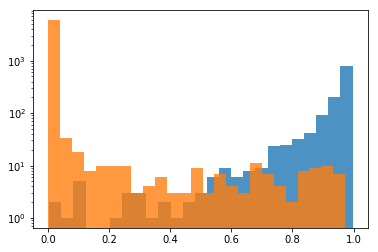

In [131]:
signal_pred = pd.DataFrame(classifier.predict_proba(df_sig_test.drop(columns=['class']).values)[:,1])
background_pred = pd.DataFrame(classifier.predict_proba(df_bkg_test.drop(columns=['class']).values)[:,1])

sns.distplot(signal_pred, kde=False, bins=25, hist_kws={'alpha': 0.8})
sns.distplot(background_pred, kde=False, bins=25, hist_kws={'alpha': 0.8})
plt.yscale('log')


In [60]:
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 100 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=200):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/100.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                print('\nbaseline increased since learning times is approaching death')
                
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.ylim([0.8, 1])
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
    

In [102]:
def build_model(df):
    """ Build the model, define the optimizer and compile the model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(13, activation='linear', input_shape=[len(df.keys())-1]),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [103]:
model = build_model(df_sig)
model.summary()    
    

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 13)                234       
_________________________________________________________________
dense_54 (Dense)             (None, 16)                224       
_________________________________________________________________
dense_55 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_56 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 34        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [104]:
# learning_rate = 0.003
EPOCHS = 200
patience = 10
df_train_set = df_train.copy(deep=True)
df_train_labels = df_train_set.pop('class')

""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])


 epochs =  0  val_loss =  0.3298811325028218
***********************************************************
baseline increased since learning times is approaching death
*************************
baseline increased since learning times is approaching death
**************** epochs =  100  val_loss =  0.09352583322022948
***************************
baseline increased since learning times is approaching death
*****
baseline increased since learning times is approaching death
*****
baseline increased since learning times is approaching death
*****
baseline increased since learning times is approaching death
*****
baseline increased since learning times is approaching death
*************
epoch 160: Reached baseline, terminating training and lost patience
Restoring model weights from the end of the best epoch.
*

In [112]:
""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])

loss, accuracy = model.evaluate(df_sig_test.iloc[:,:-1], df_sig_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for signal: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_bkg_test.iloc[:,:-1], df_bkg_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for background: {:4.2f}%".format(accuracy*100))



 Epochs =  160
Testing set accuracy for signal: 98.35%
Testing set accuracy for background: 97.87%


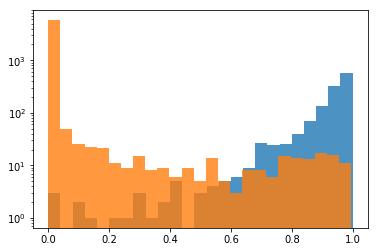

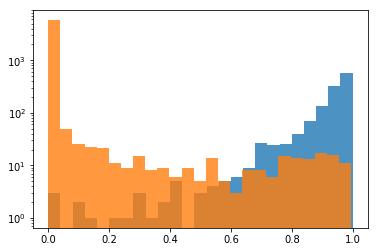

In [121]:
test_predictions_sig = model.predict(df_sig_test.iloc[:,:-1])[:,1]
test_predictions_bkg = model.predict(df_bkg_test.iloc[:,:-1])[:,1]

plt.figure()
plt.hist(test_predictions_sig, bins=25, alpha=0.8)
plt.hist(test_predictions_bkg, bins=25, alpha=0.8)
plt.yscale('log')

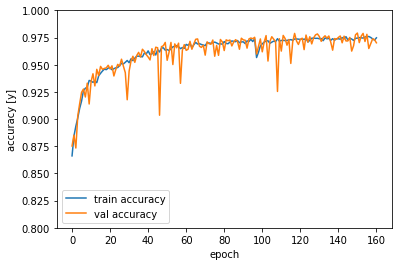

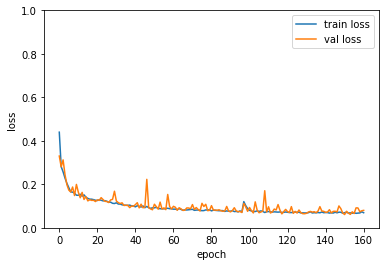

In [108]:
plot_history(history)